In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import importlib

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data/'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/'
GROUND_PATH = DATA_PATH + '/groundTruth/'
ORI_IMAGE_PATH = DATA_PATH + '/images/'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/result/'
LOG_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/logs/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test_ori.npy')
X_val = np.load(DATA_PATH + 'X_val_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_concat.npy')
y_test = np.load(DATA_PATH + 'y_test_concat.npy')
y_val = np.load(DATA_PATH + 'y_val_concat.npy')
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((200, 320, 480, 3),
 (200, 320, 480, 3),
 (100, 320, 480, 3),
 (200, 320, 480, 1),
 (200, 320, 480, 1),
 (100, 320, 480, 1))

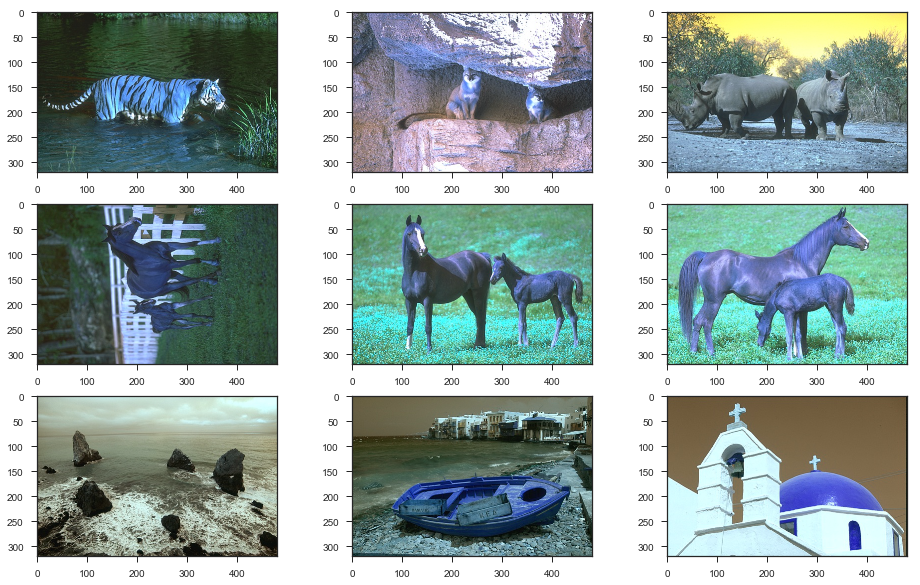

In [3]:
# Visualize training set
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i+10])
plt.show()

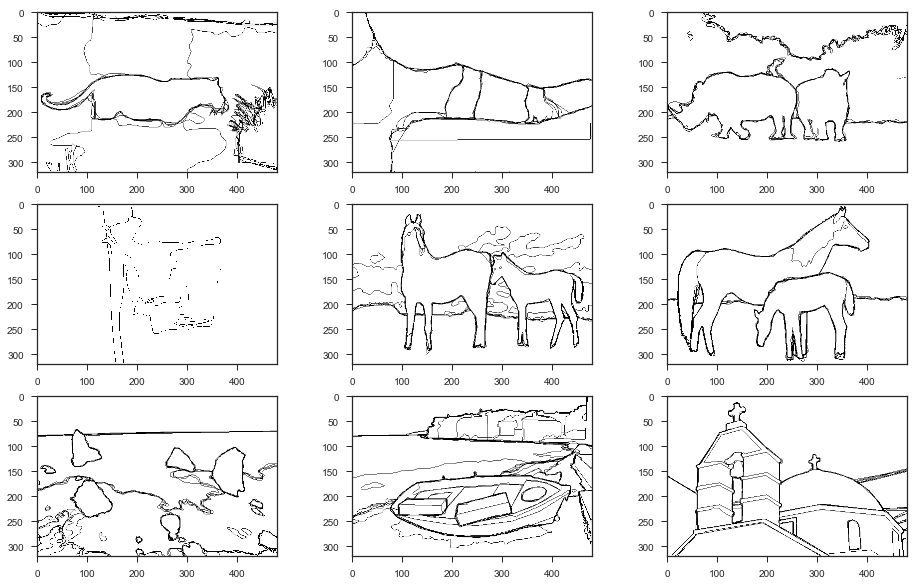

In [4]:
# Visualize Ground Truth Labels
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(y_train[i+10].reshape((320,480)), cmap='binary')
plt.show()

In [8]:
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, add, Activation, Input, \
                            Lambda, MaxPooling2D, concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.initializers import he_normal, glorot_normal
from keras import backend as K
import tensorflow as tf

from loss_functions.Loss_Functions import cross_entropy_balanced, pixel_error
from my_models.U_Net import u_net_ori

Baseline: U-Net

In [9]:
init = he_normal(seed=1)
input_shape = (320, 480, 3)

inputs = Input(shape=input_shape)
# Normalization
s = Lambda(lambda x: x / 255)(inputs)
# Block 1
c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv_1a', kernel_initializer=init)(s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv_1b', kernel_initializer=init)(c1)
p1 = MaxPooling2D((2, 2), name='pool_1')(c1)
# Block 2
c2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv_2a', kernel_initializer=init)(p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv_2b', kernel_initializer=init)(c2)
p2 = MaxPooling2D((2, 2), name='pool_2')(c2)
# Block 3
c3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_3a', kernel_initializer=init)(p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_3b', kernel_initializer=init)(c3)
p3 = MaxPooling2D((2, 2), name='pool_3')(c3)
# Block 4
c4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_4a', kernel_initializer=init)(p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_4b', kernel_initializer=init)(c4)
p4 = MaxPooling2D((2, 2), name='pool_4')(c4)
# Block 5
c5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_5a', kernel_initializer=init)(p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_5b', kernel_initializer=init)(c5)
# Block 6
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='upconv_6', kernel_initializer=init)(c5)
u6 = concatenate([u6, c4], name='concat_6')
c6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_6a', kernel_initializer=init)(u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_6b', kernel_initializer=init)(c6)
# Block 7
u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='upconv_7', kernel_initializer=init)(c6)
u7 = concatenate([u7, c3], name='concat_7')
c7 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_7a', kernel_initializer=init)(u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_7b', kernel_initializer=init)(c7)
# Block 8
u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name='upconv_8', kernel_initializer=init)(c7)
u8 = concatenate([u8, c2], name='concat_8')
c8 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv_8a', kernel_initializer=init)(u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv_8b', kernel_initializer=init)(c8)
# Block 9
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', name='upconv_9', kernel_initializer=init)(c8)
u9 = concatenate([u9, c1], name='concat_9')
c9 = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv_9a', kernel_initializer=init)(u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv_9b', kernel_initializer=init)(c9)
# Output
outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=init)(c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 320, 480, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv_1a (Conv2D)                (None, 320, 480, 8)  224         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv_1b (Conv2D)                (None, 320, 480, 8)  584         conv_1a[0][0]                    
__________________________________________________________________________________________________
pool_1 (Ma

In [10]:
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=1e-5)
checkpointer = ModelCheckpoint('model_UNET_Tu_v1.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH, write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet.compile(optimizer=optimizer, loss=cross_entropy_balanced, metrics=[pixel_error])

results = model_unet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=5, epochs=200, 
                    callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/200


Epoch 00001: val_loss improved from inf to 0.06285, saving model to model_UNET_Tu_v1.h5


 - 6s - loss: 0.0611 - pixel_error: 0.4467 - val_loss: 0.0629 - val_pixel_error: 0.4915


Epoch 2/200


Epoch 00002: val_loss improved from 0.06285 to 0.05930, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0561 - pixel_error: 0.3371 - val_loss: 0.0593 - val_pixel_error: 0.3450


Epoch 3/200


Epoch 00003: val_loss improved from 0.05930 to 0.05702, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0522 - pixel_error: 0.3204 - val_loss: 0.0570 - val_pixel_error: 0.3779


Epoch 4/200


Epoch 00004: val_loss improved from 0.05702 to 0.05525, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0503 - pixel_error: 0.3296 - val_loss: 0.0553 - val_pixel_error: 0.2334


Epoch 5/200


Epoch 00005: val_loss improved from 0.05525 to 0.05372, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0489 - pixel_error: 0.3006 - val_loss: 0.0537 - val_pixel_error: 0.3783


Epoch 6/200


Epoch 00006: val_loss improved from 0.05372 to 0.05360, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0481 - pixel_error: 0.2984 - val_loss: 0.0536 - val_pixel_error: 0.3278


Epoch 7/200


Epoch 00007: val_loss improved from 0.05360 to 0.05232, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0469 - pixel_error: 0.2876 - val_loss: 0.0523 - val_pixel_error: 0.3131


Epoch 8/200


Epoch 00008: val_loss did not improve
 - 6s - loss: 0.0478 - pixel_error: 0.2932 - val_loss: 0.0524 - val_pixel_error: 0.2845


Epoch 9/200


Epoch 00009: val_loss improved from 0.05232 to 0.05231, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0460 - pixel_error: 0.2836 - val_loss: 0.0523 - val_pixel_error: 0.3421


Epoch 10/200


Epoch 00010: val_loss did not improve
 - 6s - loss: 0.0454 - pixel_error: 0.2903 - val_loss: 0.0534 - val_pixel_error: 0.2576


Epoch 11/200


Epoch 00011: val_loss did not improve
 - 6s - loss: 0.0454 - pixel_error: 0.2782 - val_loss: 0.0539 - val_pixel_error: 0.2378


Epoch 12/200


Epoch 00012: val_loss improved from 0.05231 to 0.05147, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0444 - pixel_error: 0.2756 - val_loss: 0.0515 - val_pixel_error: 0.2674


Epoch 13/200


Epoch 00013: val_loss did not improve
 - 6s - loss: 0.0439 - pixel_error: 0.2729 - val_loss: 0.0520 - val_pixel_error: 0.3753


Epoch 14/200


Epoch 00014: val_loss improved from 0.05147 to 0.05122, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0443 - pixel_error: 0.2792 - val_loss: 0.0512 - val_pixel_error: 0.2298


Epoch 15/200


Epoch 00015: val_loss did not improve
 - 6s - loss: 0.0441 - pixel_error: 0.2747 - val_loss: 0.0516 - val_pixel_error: 0.2496


Epoch 16/200


Epoch 00016: val_loss did not improve
 - 6s - loss: 0.0428 - pixel_error: 0.2679 - val_loss: 0.0517 - val_pixel_error: 0.2623


Epoch 17/200


Epoch 00017: val_loss improved from 0.05122 to 0.05111, saving model to model_UNET_Tu_v1.h5
 - 6s - loss: 0.0425 - pixel_error: 0.2599 - val_loss: 0.0511 - val_pixel_error: 0.3750


Epoch 18/200


Epoch 00018: val_loss did not improve
 - 6s - loss: 0.0421 - pixel_error: 0.2554 - val_loss: 0.0527 - val_pixel_error: 0.2687


Epoch 19/200


Epoch 00019: val_loss did not improve
 - 6s - loss: 0.0419 - pixel_error: 0.2620 - val_loss: 0.0515 - val_pixel_error: 0.2968


Epoch 20/200


Epoch 00020: val_loss did not improve
 - 6s - loss: 0.0411 - pixel_error: 0.2556 - val_loss: 0.0519 - val_pixel_error: 0.2302


Epoch 21/200


Epoch 00021: val_loss did not improve
 - 6s - loss: 0.0405 - pixel_error: 0.2548 - val_loss: 0.0524 - val_pixel_error: 0.2345


Epoch 22/200


Epoch 00022: val_loss did not improve
 - 6s - loss: 0.0393 - pixel_error: 0.2513 - val_loss: 0.0517 - val_pixel_error: 0.2946


Epoch 23/200


Epoch 00023: val_loss did not improve
 - 6s - loss: 0.0388 - pixel_error: 0.2486 - val_loss: 0.0613 - val_pixel_error: 0.1577


Epoch 24/200


Epoch 00024: val_loss did not improve
 - 6s - loss: 0.0380 - pixel_error: 0.2426 - val_loss: 0.0546 - val_pixel_error: 0.2857


Epoch 25/200


Epoch 00025: val_loss did not improve
 - 6s - loss: 0.0377 - pixel_error: 0.2494 - val_loss: 0.0565 - val_pixel_error: 0.2456


Epoch 26/200


Epoch 00026: val_loss did not improve
 - 6s - loss: 0.0368 - pixel_error: 0.2417 - val_loss: 0.0561 - val_pixel_error: 0.2284


Epoch 27/200


Epoch 00027: val_loss did not improve
 - 6s - loss: 0.0354 - pixel_error: 0.2356 - val_loss: 0.0591 - val_pixel_error: 0.2401


Epoch 28/200


Epoch 00028: val_loss did not improve
 - 6s - loss: 0.0349 - pixel_error: 0.2314 - val_loss: 0.0576 - val_pixel_error: 0.2255


Epoch 29/200


Epoch 00029: val_loss did not improve
 - 6s - loss: 0.0338 - pixel_error: 0.2298 - val_loss: 0.0565 - val_pixel_error: 0.3280


Epoch 30/200


Epoch 00030: val_loss did not improve
 - 6s - loss: 0.0333 - pixel_error: 0.2260 - val_loss: 0.0649 - val_pixel_error: 0.2247


Epoch 31/200


Epoch 00031: val_loss did not improve
 - 6s - loss: 0.0312 - pixel_error: 0.2182 - val_loss: 0.0653 - val_pixel_error: 0.2184


Epoch 32/200


Epoch 00032: val_loss did not improve
 - 6s - loss: 0.0305 - pixel_error: 0.2125 - val_loss: 0.0820 - val_pixel_error: 0.1560


Epoch 33/200


Epoch 00033: val_loss did not improve
 - 6s - loss: 0.0295 - pixel_error: 0.2076 - val_loss: 0.0732 - val_pixel_error: 0.2245


Epoch 34/200


Epoch 00034: val_loss did not improve
 - 6s - loss: 0.0287 - pixel_error: 0.2079 - val_loss: 0.0741 - val_pixel_error: 0.2513


Epoch 35/200


Epoch 00035: val_loss did not improve
 - 6s - loss: 0.0286 - pixel_error: 0.2050 - val_loss: 0.0764 - val_pixel_error: 0.2471


Epoch 36/200


Epoch 00036: val_loss did not improve
 - 6s - loss: 0.0278 - pixel_error: 0.2056 - val_loss: 0.0888 - val_pixel_error: 0.1650


Epoch 37/200


Epoch 00037: val_loss did not improve
 - 6s - loss: 0.0267 - pixel_error: 0.1965 - val_loss: 0.0984 - val_pixel_error: 0.1788


Epoch 38/200


Epoch 00038: val_loss did not improve
 - 6s - loss: 0.0262 - pixel_error: 0.1961 - val_loss: 0.1234 - val_pixel_error: 0.1549


Epoch 39/200


Epoch 00039: val_loss did not improve
 - 6s - loss: 0.0257 - pixel_error: 0.1945 - val_loss: 0.0840 - val_pixel_error: 0.2520


Epoch 40/200


Epoch 00040: val_loss did not improve
 - 5s - loss: 0.0257 - pixel_error: 0.1941 - val_loss: 0.0933 - val_pixel_error: 0.2240


Epoch 41/200


Epoch 00041: val_loss did not improve
 - 6s - loss: 0.0275 - pixel_error: 0.2002 - val_loss: 0.1004 - val_pixel_error: 0.1664


Epoch 42/200


Epoch 00042: val_loss did not improve
 - 6s - loss: 0.0254 - pixel_error: 0.1903 - val_loss: 0.1050 - val_pixel_error: 0.1857


Epoch 43/200


Epoch 00043: val_loss did not improve
 - 5s - loss: 0.0246 - pixel_error: 0.1860 - val_loss: 0.1027 - val_pixel_error: 0.1931


Epoch 44/200


Epoch 00044: val_loss did not improve
 - 5s - loss: 0.0235 - pixel_error: 0.1809 - val_loss: 0.1085 - val_pixel_error: 0.1989


Epoch 45/200


Epoch 00045: val_loss did not improve
 - 5s - loss: 0.0234 - pixel_error: 0.1782 - val_loss: 0.1231 - val_pixel_error: 0.1592


Epoch 46/200


Epoch 00046: val_loss did not improve
 - 5s - loss: 0.0227 - pixel_error: 0.1789 - val_loss: 0.1427 - val_pixel_error: 0.1562


Epoch 47/200


Epoch 00047: val_loss did not improve
 - 5s - loss: 0.0232 - pixel_error: 0.1768 - val_loss: 0.1368 - val_pixel_error: 0.1559


Epoch 48/200


Epoch 00048: val_loss did not improve
 - 5s - loss: 0.0226 - pixel_error: 0.1748 - val_loss: 0.1389 - val_pixel_error: 0.1664


Epoch 49/200


Epoch 00049: val_loss did not improve
 - 5s - loss: 0.0220 - pixel_error: 0.1718 - val_loss: 0.1690 - val_pixel_error: 0.1316


Epoch 50/200


Epoch 00050: val_loss did not improve
 - 5s - loss: 0.0223 - pixel_error: 0.1718 - val_loss: 0.1283 - val_pixel_error: 0.1961


Epoch 51/200


Epoch 00051: val_loss did not improve
 - 5s - loss: 0.0219 - pixel_error: 0.1705 - val_loss: 0.1175 - val_pixel_error: 0.2192


Epoch 52/200


Epoch 00052: val_loss did not improve
 - 5s - loss: 0.0227 - pixel_error: 0.1751 - val_loss: 0.1433 - val_pixel_error: 0.1651


Epoch 53/200


Epoch 00053: val_loss did not improve
 - 5s - loss: 0.0214 - pixel_error: 0.1653 - val_loss: 0.1413 - val_pixel_error: 0.1817


Epoch 54/200


Epoch 00054: val_loss did not improve
 - 5s - loss: 0.0205 - pixel_error: 0.1633 - val_loss: 0.1647 - val_pixel_error: 0.1577


Epoch 55/200


Epoch 00055: val_loss did not improve
 - 5s - loss: 0.0204 - pixel_error: 0.1588 - val_loss: 0.1628 - val_pixel_error: 0.1656


Epoch 56/200


Epoch 00056: val_loss did not improve
 - 5s - loss: 0.0204 - pixel_error: 0.1591 - val_loss: 0.1349 - val_pixel_error: 0.2011


Epoch 57/200


Epoch 00057: val_loss did not improve
 - 5s - loss: 0.0209 - pixel_error: 0.1617 - val_loss: 0.1731 - val_pixel_error: 0.1623


Epoch 58/200


Epoch 00058: val_loss did not improve
 - 5s - loss: 0.0204 - pixel_error: 0.1595 - val_loss: 0.1437 - val_pixel_error: 0.1789


Epoch 59/200


Epoch 00059: val_loss did not improve
 - 5s - loss: 0.0200 - pixel_error: 0.1591 - val_loss: 0.1701 - val_pixel_error: 0.1514


Epoch 60/200


Epoch 00060: val_loss did not improve
 - 5s - loss: 0.0198 - pixel_error: 0.1555 - val_loss: 0.1916 - val_pixel_error: 0.1493


Epoch 61/200


Epoch 00061: val_loss did not improve
 - 5s - loss: 0.0195 - pixel_error: 0.1532 - val_loss: 0.1955 - val_pixel_error: 0.1311


Epoch 62/200


Epoch 00062: val_loss did not improve
 - 5s - loss: 0.0195 - pixel_error: 0.1544 - val_loss: 0.1622 - val_pixel_error: 0.1633


Epoch 63/200


Epoch 00063: val_loss did not improve
 - 5s - loss: 0.0194 - pixel_error: 0.1533 - val_loss: 0.1770 - val_pixel_error: 0.1516


Epoch 64/200


Epoch 00064: val_loss did not improve
 - 5s - loss: 0.0197 - pixel_error: 0.1549 - val_loss: 0.1637 - val_pixel_error: 0.1730


Epoch 65/200


Epoch 00065: val_loss did not improve
 - 5s - loss: 0.0196 - pixel_error: 0.1549 - val_loss: 0.1820 - val_pixel_error: 0.1452


Epoch 66/200


Epoch 00066: val_loss did not improve
 - 5s - loss: 0.0194 - pixel_error: 0.1517 - val_loss: 0.2052 - val_pixel_error: 0.1189


Epoch 67/200


Epoch 00067: val_loss did not improve
 - 5s - loss: 0.0197 - pixel_error: 0.1551 - val_loss: 0.1490 - val_pixel_error: 0.1961


Epoch 68/200


Epoch 00068: val_loss did not improve
 - 5s - loss: 0.0193 - pixel_error: 0.1531 - val_loss: 0.1683 - val_pixel_error: 0.1600


Epoch 69/200


Epoch 00069: val_loss did not improve
 - 5s - loss: 0.0192 - pixel_error: 0.1508 - val_loss: 0.1678 - val_pixel_error: 0.1653


Epoch 70/200


Epoch 00070: val_loss did not improve
 - 5s - loss: 0.0186 - pixel_error: 0.1480 - val_loss: 0.2142 - val_pixel_error: 0.1244


Epoch 71/200


Epoch 00071: val_loss did not improve
 - 5s - loss: 0.0183 - pixel_error: 0.1447 - val_loss: 0.1682 - val_pixel_error: 0.1904


Epoch 72/200


Epoch 00072: val_loss did not improve
 - 5s - loss: 0.0186 - pixel_error: 0.1464 - val_loss: 0.2271 - val_pixel_error: 0.1079


Epoch 73/200


Epoch 00073: val_loss did not improve
 - 5s - loss: 0.0182 - pixel_error: 0.1454 - val_loss: 0.1967 - val_pixel_error: 0.1437


Epoch 74/200


Epoch 00074: val_loss did not improve
 - 5s - loss: 0.0180 - pixel_error: 0.1432 - val_loss: 0.2153 - val_pixel_error: 0.1357


Epoch 75/200


Epoch 00075: val_loss did not improve
 - 5s - loss: 0.0179 - pixel_error: 0.1417 - val_loss: 0.2198 - val_pixel_error: 0.1131


Epoch 76/200


Epoch 00076: val_loss did not improve
 - 5s - loss: 0.0179 - pixel_error: 0.1430 - val_loss: 0.2231 - val_pixel_error: 0.1305


Epoch 77/200


Epoch 00077: val_loss did not improve
 - 5s - loss: 0.0178 - pixel_error: 0.1406 - val_loss: 0.2127 - val_pixel_error: 0.1320


Epoch 78/200


Epoch 00078: val_loss did not improve
 - 5s - loss: 0.0172 - pixel_error: 0.1378 - val_loss: 0.2012 - val_pixel_error: 0.1518


Epoch 79/200


Epoch 00079: val_loss did not improve
 - 5s - loss: 0.0175 - pixel_error: 0.1375 - val_loss: 0.1881 - val_pixel_error: 0.1709


Epoch 80/200


Epoch 00080: val_loss did not improve
 - 5s - loss: 0.0182 - pixel_error: 0.1412 - val_loss: 0.2139 - val_pixel_error: 0.1266


Epoch 81/200


Epoch 00081: val_loss did not improve
 - 5s - loss: 0.0186 - pixel_error: 0.1459 - val_loss: 0.1960 - val_pixel_error: 0.1362


Epoch 82/200


Epoch 00082: val_loss did not improve
 - 5s - loss: 0.0177 - pixel_error: 0.1382 - val_loss: 0.1708 - val_pixel_error: 0.1818


Epoch 83/200


Epoch 00083: val_loss did not improve
 - 5s - loss: 0.0177 - pixel_error: 0.1398 - val_loss: 0.1954 - val_pixel_error: 0.1474


Epoch 84/200



Epoch 00084: reducing learning rate to 0.00020000000949949026.
Epoch 00084: val_loss did not improve
 - 5s - loss: 0.0172 - pixel_error: 0.1364 - val_loss: 0.2179 - val_pixel_error: 0.1367


Epoch 85/200


Epoch 00085: val_loss did not improve
 - 5s - loss: 0.0162 - pixel_error: 0.1317 - val_loss: 0.2309 - val_pixel_error: 0.1278


Epoch 86/200


Epoch 00086: val_loss did not improve
 - 5s - loss: 0.0158 - pixel_error: 0.1269 - val_loss: 0.2703 - val_pixel_error: 0.1062


Epoch 87/200


Epoch 00087: val_loss did not improve
 - 5s - loss: 0.0155 - pixel_error: 0.1243 - val_loss: 0.2668 - val_pixel_error: 0.1147


Epoch 88/200


Epoch 00088: val_loss did not improve
 - 5s - loss: 0.0154 - pixel_error: 0.1232 - val_loss: 0.2848 - val_pixel_error: 0.1057


Epoch 89/200


Epoch 00089: val_loss did not improve
 - 5s - loss: 0.0150 - pixel_error: 0.1222 - val_loss: 0.2985 - val_pixel_error: 0.1020


Epoch 90/200


Epoch 00090: val_loss did not improve
 - 5s - loss: 0.0153 - pixel_error: 0.1215 - val_loss: 0.2910 - val_pixel_error: 0.1120


Epoch 91/200


Epoch 00091: val_loss did not improve
 - 5s - loss: 0.0150 - pixel_error: 0.1208 - val_loss: 0.3032 - val_pixel_error: 0.1040


Epoch 92/200


Epoch 00092: val_loss did not improve
 - 5s - loss: 0.0148 - pixel_error: 0.1196 - val_loss: 0.3128 - val_pixel_error: 0.1019


Epoch 93/200


Epoch 00093: val_loss did not improve
 - 5s - loss: 0.0148 - pixel_error: 0.1190 - val_loss: 0.3067 - val_pixel_error: 0.1087


Epoch 94/200


Epoch 00094: val_loss did not improve
 - 5s - loss: 0.0147 - pixel_error: 0.1198 - val_loss: 0.3324 - val_pixel_error: 0.0948


Epoch 95/200


Epoch 00095: val_loss did not improve
 - 5s - loss: 0.0146 - pixel_error: 0.1180 - val_loss: 0.3229 - val_pixel_error: 0.1038


Epoch 96/200


Epoch 00096: val_loss did not improve
 - 5s - loss: 0.0144 - pixel_error: 0.1177 - val_loss: 0.3221 - val_pixel_error: 0.1035


Epoch 97/200


Epoch 00097: val_loss did not improve
 - 5s - loss: 0.0146 - pixel_error: 0.1173 - val_loss: 0.3484 - val_pixel_error: 0.0920


Epoch 98/200


Epoch 00098: val_loss did not improve
 - 5s - loss: 0.0145 - pixel_error: 0.1172 - val_loss: 0.3368 - val_pixel_error: 0.0976


Epoch 99/200


Epoch 00099: val_loss did not improve
 - 5s - loss: 0.0143 - pixel_error: 0.1161 - val_loss: 0.3442 - val_pixel_error: 0.0991


Epoch 100/200


Epoch 00100: val_loss did not improve
 - 5s - loss: 0.0142 - pixel_error: 0.1154 - val_loss: 0.3293 - val_pixel_error: 0.1049


Epoch 101/200


Epoch 00101: val_loss did not improve
 - 5s - loss: 0.0142 - pixel_error: 0.1169 - val_loss: 0.3614 - val_pixel_error: 0.0913


Epoch 102/200


Epoch 00102: val_loss did not improve
 - 5s - loss: 0.0141 - pixel_error: 0.1155 - val_loss: 0.3368 - val_pixel_error: 0.1071


Epoch 103/200


Epoch 00103: val_loss did not improve
 - 5s - loss: 0.0139 - pixel_error: 0.1151 - val_loss: 0.3467 - val_pixel_error: 0.1027


Epoch 104/200


Epoch 00104: val_loss did not improve
 - 5s - loss: 0.0140 - pixel_error: 0.1152 - val_loss: 0.3384 - val_pixel_error: 0.1087


Epoch 105/200


Epoch 00105: val_loss did not improve
 - 5s - loss: 0.0139 - pixel_error: 0.1144 - val_loss: 0.3540 - val_pixel_error: 0.1000


Epoch 106/200


Epoch 00106: val_loss did not improve
 - 5s - loss: 0.0142 - pixel_error: 0.1148 - val_loss: 0.3399 - val_pixel_error: 0.1066


Epoch 107/200


Epoch 00107: val_loss did not improve
 - 5s - loss: 0.0140 - pixel_error: 0.1142 - val_loss: 0.3555 - val_pixel_error: 0.1001


Epoch 108/200


Epoch 00108: val_loss did not improve
 - 5s - loss: 0.0140 - pixel_error: 0.1140 - val_loss: 0.3673 - val_pixel_error: 0.0948


Epoch 109/200


Epoch 00109: val_loss did not improve
 - 5s - loss: 0.0138 - pixel_error: 0.1137 - val_loss: 0.3679 - val_pixel_error: 0.0959


Epoch 110/200


Epoch 00110: val_loss did not improve
 - 5s - loss: 0.0138 - pixel_error: 0.1127 - val_loss: 0.3619 - val_pixel_error: 0.0981


Epoch 111/200


Epoch 00111: val_loss did not improve
 - 5s - loss: 0.0139 - pixel_error: 0.1127 - val_loss: 0.3454 - val_pixel_error: 0.1089


Epoch 112/200


Epoch 00112: val_loss did not improve
 - 5s - loss: 0.0138 - pixel_error: 0.1132 - val_loss: 0.3730 - val_pixel_error: 0.0958


Epoch 113/200


Epoch 00113: val_loss did not improve
 - 5s - loss: 0.0137 - pixel_error: 0.1126 - val_loss: 0.3817 - val_pixel_error: 0.0904


Epoch 114/200


Epoch 00114: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1123 - val_loss: 0.3680 - val_pixel_error: 0.0993


Epoch 115/200


Epoch 00115: val_loss did not improve
 - 5s - loss: 0.0137 - pixel_error: 0.1114 - val_loss: 0.3594 - val_pixel_error: 0.1038


Epoch 116/200


Epoch 00116: val_loss did not improve
 - 5s - loss: 0.0137 - pixel_error: 0.1121 - val_loss: 0.3689 - val_pixel_error: 0.1007


Epoch 117/200


Epoch 00117: val_loss did not improve
 - 5s - loss: 0.0138 - pixel_error: 0.1112 - val_loss: 0.3843 - val_pixel_error: 0.0937


Epoch 118/200


Epoch 00118: val_loss did not improve
 - 5s - loss: 0.0137 - pixel_error: 0.1110 - val_loss: 0.3994 - val_pixel_error: 0.0867


Epoch 119/200


Epoch 00119: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1105 - val_loss: 0.3915 - val_pixel_error: 0.0909


Epoch 120/200


Epoch 00120: val_loss did not improve
 - 5s - loss: 0.0134 - pixel_error: 0.1102 - val_loss: 0.3946 - val_pixel_error: 0.0898


Epoch 121/200


Epoch 00121: val_loss did not improve
 - 5s - loss: 0.0133 - pixel_error: 0.1095 - val_loss: 0.3892 - val_pixel_error: 0.0941


Epoch 122/200


Epoch 00122: val_loss did not improve
 - 5s - loss: 0.0136 - pixel_error: 0.1097 - val_loss: 0.3785 - val_pixel_error: 0.0989


Epoch 123/200


Epoch 00123: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1100 - val_loss: 0.3695 - val_pixel_error: 0.1043


Epoch 124/200


Epoch 00124: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1098 - val_loss: 0.3889 - val_pixel_error: 0.0927


Epoch 125/200


Epoch 00125: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1094 - val_loss: 0.3921 - val_pixel_error: 0.0952


Epoch 126/200


Epoch 00126: val_loss did not improve
 - 5s - loss: 0.0132 - pixel_error: 0.1102 - val_loss: 0.3837 - val_pixel_error: 0.0976


Epoch 127/200


Epoch 00127: val_loss did not improve
 - 5s - loss: 0.0134 - pixel_error: 0.1106 - val_loss: 0.3740 - val_pixel_error: 0.1025


Epoch 128/200


Epoch 00128: val_loss did not improve
 - 5s - loss: 0.0135 - pixel_error: 0.1116 - val_loss: 0.3871 - val_pixel_error: 0.0943


Epoch 129/200


Epoch 00129: val_loss did not improve
 - 5s - loss: 0.0136 - pixel_error: 0.1097 - val_loss: 0.3792 - val_pixel_error: 0.0996


Epoch 130/200


Epoch 00130: val_loss did not improve
 - 5s - loss: 0.0136 - pixel_error: 0.1088 - val_loss: 0.3822 - val_pixel_error: 0.0985


Epoch 131/200


Epoch 00131: val_loss did not improve
 - 5s - loss: 0.0134 - pixel_error: 0.1097 - val_loss: 0.3786 - val_pixel_error: 0.0997


Epoch 132/200



Epoch 00132: reducing learning rate to 4.0000001899898055e-05.
Epoch 00132: val_loss did not improve
 - 5s - loss: 0.0132 - pixel_error: 0.1089 - val_loss: 0.3955 - val_pixel_error: 0.0937


Epoch 133/200


Epoch 00133: val_loss did not improve
 - 5s - loss: 0.0132 - pixel_error: 0.1075 - val_loss: 0.4030 - val_pixel_error: 0.0902


Epoch 134/200


Epoch 00134: val_loss did not improve
 - 5s - loss: 0.0131 - pixel_error: 0.1061 - val_loss: 0.3993 - val_pixel_error: 0.0919


Epoch 135/200


Epoch 00135: val_loss did not improve
 - 5s - loss: 0.0131 - pixel_error: 0.1053 - val_loss: 0.4019 - val_pixel_error: 0.0916


Epoch 136/200


Epoch 00136: val_loss did not improve
 - 5s - loss: 0.0129 - pixel_error: 0.1054 - val_loss: 0.4034 - val_pixel_error: 0.0915


Epoch 137/200


Epoch 00137: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1053 - val_loss: 0.4079 - val_pixel_error: 0.0900


Epoch 138/200


Epoch 00138: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1051 - val_loss: 0.4110 - val_pixel_error: 0.0890


Epoch 139/200


Epoch 00139: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1050 - val_loss: 0.4147 - val_pixel_error: 0.0875


Epoch 140/200


Epoch 00140: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1048 - val_loss: 0.4147 - val_pixel_error: 0.0880


Epoch 141/200


Epoch 00141: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1047 - val_loss: 0.4119 - val_pixel_error: 0.0892


Epoch 142/200


Epoch 00142: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1046 - val_loss: 0.4186 - val_pixel_error: 0.0873


Epoch 143/200


Epoch 00143: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1046 - val_loss: 0.4152 - val_pixel_error: 0.0883


Epoch 144/200


Epoch 00144: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1042 - val_loss: 0.4145 - val_pixel_error: 0.0894


Epoch 145/200


Epoch 00145: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1044 - val_loss: 0.4233 - val_pixel_error: 0.0856


Epoch 146/200


Epoch 00146: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1037 - val_loss: 0.4054 - val_pixel_error: 0.0939


Epoch 147/200


Epoch 00147: val_loss did not improve
 - 5s - loss: 0.0129 - pixel_error: 0.1043 - val_loss: 0.4192 - val_pixel_error: 0.0873


Epoch 148/200


Epoch 00148: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1045 - val_loss: 0.4205 - val_pixel_error: 0.0876


Epoch 149/200



Epoch 00149: reducing learning rate to 1e-05.
Epoch 00149: val_loss did not improve
 - 5s - loss: 0.0128 - pixel_error: 0.1036 - val_loss: 0.4221 - val_pixel_error: 0.0868


Epoch 150/200


Epoch 00150: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1036 - val_loss: 0.4198 - val_pixel_error: 0.0882


Epoch 151/200


Epoch 00151: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1039 - val_loss: 0.4265 - val_pixel_error: 0.0852


Epoch 152/200


Epoch 00152: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1030 - val_loss: 0.4172 - val_pixel_error: 0.0893


Epoch 153/200


Epoch 00153: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1036 - val_loss: 0.4177 - val_pixel_error: 0.0893


Epoch 154/200


Epoch 00154: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1040 - val_loss: 0.4216 - val_pixel_error: 0.0879


Epoch 155/200


Epoch 00155: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1037 - val_loss: 0.4217 - val_pixel_error: 0.0880


Epoch 156/200


Epoch 00156: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1035 - val_loss: 0.4213 - val_pixel_error: 0.0882


Epoch 157/200


Epoch 00157: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1035 - val_loss: 0.4204 - val_pixel_error: 0.0885


Epoch 158/200


Epoch 00158: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1033 - val_loss: 0.4215 - val_pixel_error: 0.0882


Epoch 159/200


Epoch 00159: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1034 - val_loss: 0.4208 - val_pixel_error: 0.0884


Epoch 160/200


Epoch 00160: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1034 - val_loss: 0.4260 - val_pixel_error: 0.0862


Epoch 161/200


Epoch 00161: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1034 - val_loss: 0.4221 - val_pixel_error: 0.0882


Epoch 162/200


Epoch 00162: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1034 - val_loss: 0.4237 - val_pixel_error: 0.0876


Epoch 163/200


Epoch 00163: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1033 - val_loss: 0.4203 - val_pixel_error: 0.0891


Epoch 164/200


Epoch 00164: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1034 - val_loss: 0.4253 - val_pixel_error: 0.0868


Epoch 165/200


Epoch 00165: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1035 - val_loss: 0.4267 - val_pixel_error: 0.0866


Epoch 166/200


Epoch 00166: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1031 - val_loss: 0.4250 - val_pixel_error: 0.0871


Epoch 167/200


Epoch 00167: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1028 - val_loss: 0.4232 - val_pixel_error: 0.0880


Epoch 168/200


Epoch 00168: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1030 - val_loss: 0.4251 - val_pixel_error: 0.0871


Epoch 169/200


Epoch 00169: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1033 - val_loss: 0.4285 - val_pixel_error: 0.0858


Epoch 170/200


Epoch 00170: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1031 - val_loss: 0.4267 - val_pixel_error: 0.0869


Epoch 171/200


Epoch 00171: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1034 - val_loss: 0.4263 - val_pixel_error: 0.0872


Epoch 172/200


Epoch 00172: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1027 - val_loss: 0.4257 - val_pixel_error: 0.0872


Epoch 173/200


Epoch 00173: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1032 - val_loss: 0.4246 - val_pixel_error: 0.0879


Epoch 174/200


Epoch 00174: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1031 - val_loss: 0.4263 - val_pixel_error: 0.0872


Epoch 175/200


Epoch 00175: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1029 - val_loss: 0.4239 - val_pixel_error: 0.0883


Epoch 176/200


Epoch 00176: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1029 - val_loss: 0.4257 - val_pixel_error: 0.0876


Epoch 177/200


Epoch 00177: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1033 - val_loss: 0.4308 - val_pixel_error: 0.0855


Epoch 178/200


Epoch 00178: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1029 - val_loss: 0.4270 - val_pixel_error: 0.0874


Epoch 179/200


Epoch 00179: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1029 - val_loss: 0.4272 - val_pixel_error: 0.0871


Epoch 180/200


Epoch 00180: val_loss did not improve
 - 5s - loss: 0.0123 - pixel_error: 0.1030 - val_loss: 0.4308 - val_pixel_error: 0.0857


Epoch 181/200


Epoch 00181: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1025 - val_loss: 0.4267 - val_pixel_error: 0.0875


Epoch 182/200


Epoch 00182: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1030 - val_loss: 0.4277 - val_pixel_error: 0.0872


Epoch 183/200


Epoch 00183: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1028 - val_loss: 0.4315 - val_pixel_error: 0.0855


Epoch 184/200


Epoch 00184: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1029 - val_loss: 0.4324 - val_pixel_error: 0.0853


Epoch 185/200


Epoch 00185: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1025 - val_loss: 0.4301 - val_pixel_error: 0.0864


Epoch 186/200


Epoch 00186: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1027 - val_loss: 0.4299 - val_pixel_error: 0.0865


Epoch 187/200


Epoch 00187: val_loss did not improve
 - 5s - loss: 0.0123 - pixel_error: 0.1029 - val_loss: 0.4289 - val_pixel_error: 0.0873


Epoch 188/200


Epoch 00188: val_loss did not improve
 - 5s - loss: 0.0126 - pixel_error: 0.1024 - val_loss: 0.4292 - val_pixel_error: 0.0869


Epoch 189/200


Epoch 00189: val_loss did not improve
 - 5s - loss: 0.0127 - pixel_error: 0.1026 - val_loss: 0.4281 - val_pixel_error: 0.0873


Epoch 190/200


Epoch 00190: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1026 - val_loss: 0.4323 - val_pixel_error: 0.0856


Epoch 191/200


Epoch 00191: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1023 - val_loss: 0.4297 - val_pixel_error: 0.0867


Epoch 192/200


Epoch 00192: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1026 - val_loss: 0.4306 - val_pixel_error: 0.0866


Epoch 193/200


Epoch 00193: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1023 - val_loss: 0.4274 - val_pixel_error: 0.0880


Epoch 194/200


Epoch 00194: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1028 - val_loss: 0.4297 - val_pixel_error: 0.0873


Epoch 195/200


Epoch 00195: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1024 - val_loss: 0.4331 - val_pixel_error: 0.0857


Epoch 196/200


Epoch 00196: val_loss did not improve
 - 5s - loss: 0.0125 - pixel_error: 0.1026 - val_loss: 0.4337 - val_pixel_error: 0.0855


Epoch 197/200


Epoch 00197: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1022 - val_loss: 0.4320 - val_pixel_error: 0.0863


Epoch 198/200


Epoch 00198: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1023 - val_loss: 0.4283 - val_pixel_error: 0.0878


Epoch 199/200


Epoch 00199: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1025 - val_loss: 0.4311 - val_pixel_error: 0.0869


Epoch 200/200


Epoch 00200: val_loss did not improve
 - 5s - loss: 0.0124 - pixel_error: 0.1024 - val_loss: 0.4317 - val_pixel_error: 0.0865


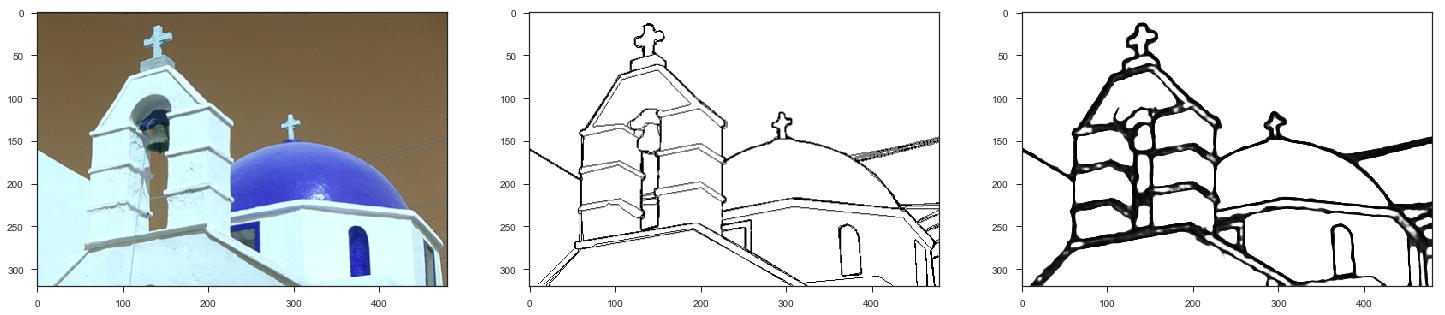

In [18]:
y_pred = model_unet.predict(X_train[18].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred_HED.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.9] = 1
# y_pred[y_pred <= 0.1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[18], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[18].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [19]:
model_unet.save_weights(WEIGHT_PATH + 'UNET_weight_base.h5')
model_unet.save(MODEL_PATH + 'UNET_model_base.h5')
model_json = model_unet.to_json()
with open(MODEL_PATH + 'UNET_model_base.json', "w") as json_file:
    json_file.write(model_json)

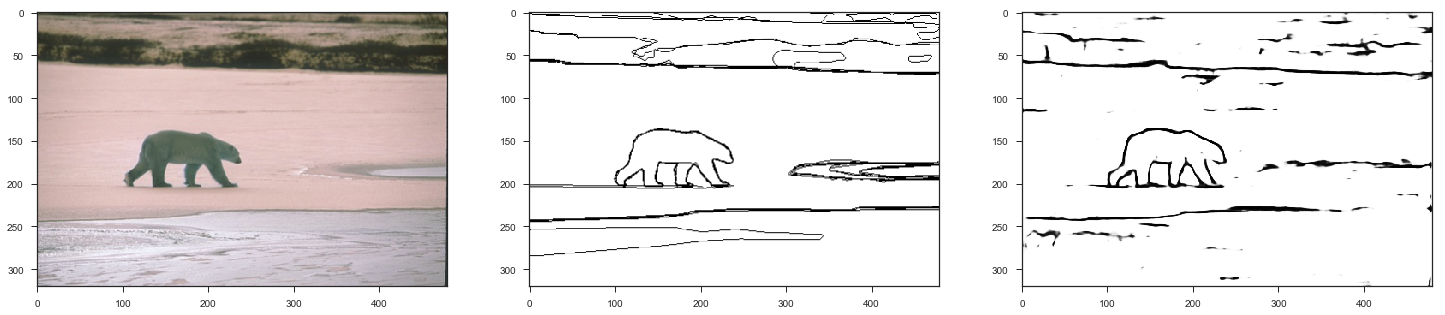

In [32]:
model_unet_load = u_net_ori(input_shape=(320, 480, 3))
model_unet_load.load_weights('/media/tulan/Linux/Pycharm/Image_Edge/weight/UNET_weight_v1.h5')

y_pred = model_unet_load.predict(X_test[0].reshape((-1,320,480,3)))[-1]
y_pred = y_pred.reshape((320, 480))
# np.savetxt(RESULT_PATH + '/sample_pred.csv', y_pred, fmt='%3f')
# y_pred[y_pred >= 0.5] = 1
# y_pred[y_pred < 0.5] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_test[0], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_test[0].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')
plt.show()